# Project 4: Regularization and Overfitting

## Goal
Understand overfitting, generalization, and regularization techniques.

## Learning Objectives
- What is overfitting vs underfitting?
- L1 vs L2 regularization
- Bias-variance tradeoff
- Training vs test loss divergence

## Theoretical Foundation

### L2 Regularization (Ridge)
$$L = MSE + \lambda \sum_{i} w_i^2$$

### L1 Regularization (Lasso)
$$L = MSE + \lambda \sum_{i} |w_i|$$

In [21]:
# Setup (dynamic path resolution, no hard-coded user path)
import sys
from pathlib import Path

def add_repo_root(marker_files=("requirements.txt","README.md",".git")):
    for candidate in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
        if any((candidate / m).exists() for m in marker_files):
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    return None

REPO_ROOT = add_repo_root()
print(f"Repo root: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
from utils.data_generators import generate_polynomial_data, generate_noisy_sine_wave

print("Ready to explore regularization!")

Repo root: /Users/mark/git/learning-ml-to-llm/projects/phase1_classical_ml
Ready to explore regularization!


## Step 1: Generate Polynomial Data and Split

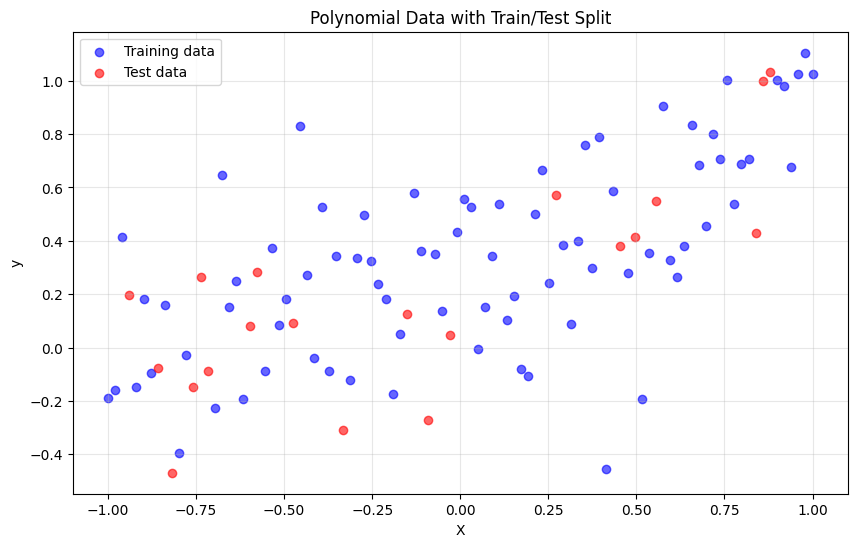

Training set size: 80
Test set size: 20
Feature range: [-1.00, 1.00]
Target range: [-0.47, 1.10]


In [22]:
# Generate polynomial data with noise
np.random.seed(42)
X, y = generate_polynomial_data(n_samples=100, degree=3, noise_std=0.3, random_state=42)

# Flatten arrays for easier handling
X = X.flatten()
y = y.flatten()

# Split into train and test sets
def train_test_split(X, y, test_size=0.2):
    """Simple train-test split without sklearn."""
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    
    # Shuffle indices
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, label='Training data', color='blue')
plt.scatter(X_test, y_test, alpha=0.6, label='Test data', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Polynomial Data with Train/Test Split')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Feature range: [{X.min():.2f}, {X.max():.2f}]")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

## Step 2: Create Polynomial Features

In [23]:
def create_polynomial_features(X, degree):
    """
    Create polynomial features up to specified degree.
    
    Parameters:
    -----------
    X : numpy array of shape (n_samples,)
        Input features
    degree : int
        Maximum polynomial degree
        
    Returns:
    --------
    numpy array of shape (n_samples, degree)
        Polynomial features [X, X^2, X^3, ..., X^degree]
    """
    n_samples = len(X)
    X_poly = np.zeros((n_samples, degree))
    
    for d in range(1, degree + 1):
        X_poly[:, d - 1] = X ** d
    
    return X_poly

# Test with different polynomial degrees
degrees_to_test = [1, 3, 10, 20]

print("Polynomial Features Examples:")
print("=" * 60)
for deg in degrees_to_test:
    X_poly = create_polynomial_features(X_train[:3], deg)
    print(f"\nDegree {deg}: Shape = {X_poly.shape}")
    print(f"First sample: {X_poly[0, :min(5, deg)]}")  # Show first 5 features

print("\n" + "=" * 60)
print("Higher degree = More complex model = Risk of overfitting!")

Polynomial Features Examples:

Degree 1: Shape = (3, 1)
First sample: [-0.07070707]

Degree 3: Shape = (3, 3)
First sample: [-0.07070707  0.00499949 -0.0003535 ]

Degree 10: Shape = (3, 10)
First sample: [-7.07070707e-02  4.99948985e-03 -3.53499282e-04  2.49948987e-05
 -1.76731607e-06]

Degree 20: Shape = (3, 20)
First sample: [-7.07070707e-02  4.99948985e-03 -3.53499282e-04  2.49948987e-05
 -1.76731607e-06]

Higher degree = More complex model = Risk of overfitting!


## Step 3: Implement Regularized Regression

In [24]:
class RegularizedRegression:
    """
    Linear regression with L1 (Lasso) or L2 (Ridge) regularization.
    """
    
    def __init__(self, regularization='l2', alpha=0.01, learning_rate=0.01, n_iterations=1000):
        """
        Initialize regularized regression.
        
        Parameters:
        -----------
        regularization : str
            Type of regularization: 'none', 'l1', or 'l2'
        alpha : float
            Regularization strength (lambda)
        learning_rate : float
            Learning rate for gradient descent
        n_iterations : int
            Number of training iterations
        """
        self.regularization = regularization
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.test_losses = []
        
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        """
        Train the model using gradient descent.
        
        Parameters:
        -----------
        X_train : numpy array of shape (n_samples, n_features)
            Training features
        y_train : numpy array of shape (n_samples,)
            Training targets
        X_test : numpy array, optional
            Test features for tracking test loss
        y_test : numpy array, optional
            Test targets for tracking test loss
        """
        n_samples, n_features = X_train.shape
        
        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.n_iterations):
            # Forward pass
            y_pred_train = np.dot(X_train, self.weights) + self.bias
            
            # Compute loss (MSE + regularization)
            mse_loss = np.mean((y_train - y_pred_train) ** 2)
            
            if self.regularization == 'l2':
                reg_loss = self.alpha * np.sum(self.weights ** 2)
            elif self.regularization == 'l1':
                reg_loss = self.alpha * np.sum(np.abs(self.weights))
            else:
                reg_loss = 0
            
            train_loss = mse_loss + reg_loss
            self.train_losses.append(train_loss)
            
            # Track test loss if test data provided
            if X_test is not None and y_test is not None:
                y_pred_test = np.dot(X_test, self.weights) + self.bias
                test_loss = np.mean((y_test - y_pred_test) ** 2)
                self.test_losses.append(test_loss)
            
            # Compute gradients
            dw = -(2 / n_samples) * np.dot(X_train.T, (y_train - y_pred_train))
            db = -(2 / n_samples) * np.sum(y_train - y_pred_train)
            
            # Add regularization to gradients
            if self.regularization == 'l2':
                dw += 2 * self.alpha * self.weights
            elif self.regularization == 'l1':
                dw += self.alpha * np.sign(self.weights)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
    def predict(self, X):
        """Predict using the trained model."""
        return np.dot(X, self.weights) + self.bias
    
    def get_mse(self, X, y):
        """Calculate MSE without regularization term."""
        y_pred = self.predict(X)
        return np.mean((y - y_pred) ** 2)

print("RegularizedRegression class implemented!")

RegularizedRegression class implemented!


## Step 4: Demonstrate Overfitting (High Degree, No Regularization)

Polynomial Degree: 15
Training MSE: 0.0704
Test MSE: 0.0693
Overfitting gap: -0.0011


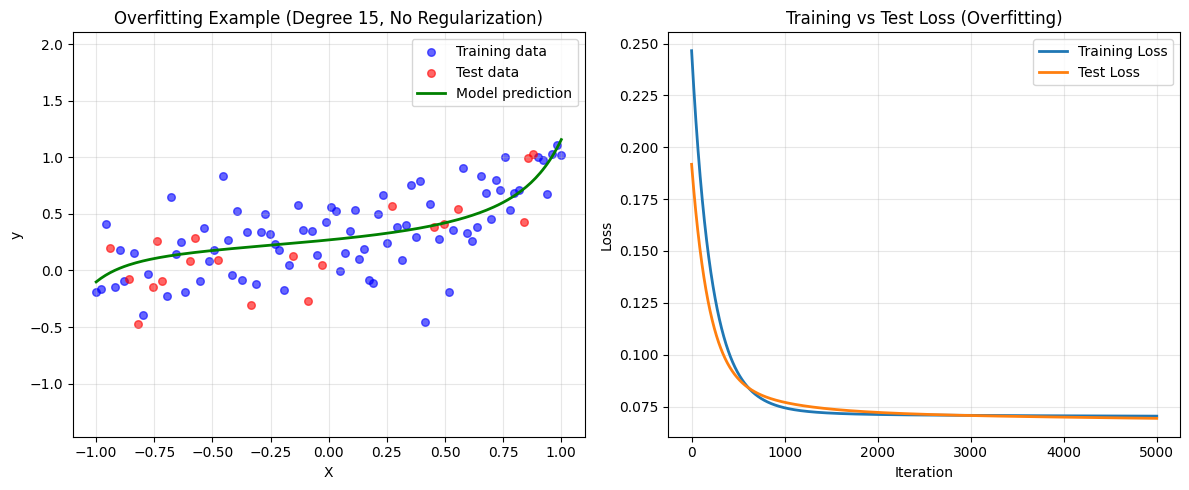


⚠️  Notice: The model fits training data well but diverges on test data!


In [25]:
# Use high-degree polynomial to demonstrate overfitting
degree = 15

# Create polynomial features
X_train_poly = create_polynomial_features(X_train, degree)
X_test_poly = create_polynomial_features(X_test, degree)

# Train without regularization
model_overfit = RegularizedRegression(regularization='none', learning_rate=0.001, n_iterations=5000)
model_overfit.fit(X_train_poly, y_train, X_test_poly, y_test)

# Calculate errors
train_mse = model_overfit.get_mse(X_train_poly, y_train)
test_mse = model_overfit.get_mse(X_test_poly, y_test)

print(f"Polynomial Degree: {degree}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Overfitting gap: {test_mse - train_mse:.4f}")

# Visualize predictions
X_plot = np.linspace(X.min(), X.max(), 200)
X_plot_poly = create_polynomial_features(X_plot, degree)
y_plot = model_overfit.predict(X_plot_poly)

plt.figure(figsize=(12, 5))

# Left plot: Fit visualization
plt.subplot(1, 2, 1)
plt.scatter(X_train, y_train, alpha=0.6, label='Training data', color='blue', s=30)
plt.scatter(X_test, y_test, alpha=0.6, label='Test data', color='red', s=30)
plt.plot(X_plot, y_plot, 'g-', linewidth=2, label='Model prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Overfitting Example (Degree {degree}, No Regularization)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(y.min() - 1, y.max() + 1)

# Right plot: Train vs Test loss
plt.subplot(1, 2, 2)
plt.plot(model_overfit.train_losses, label='Training Loss', linewidth=2)
plt.plot(model_overfit.test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training vs Test Loss (Overfitting)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️  Notice: The model fits training data well but diverges on test data!")

## Step 5: Compare Models with Different Complexity

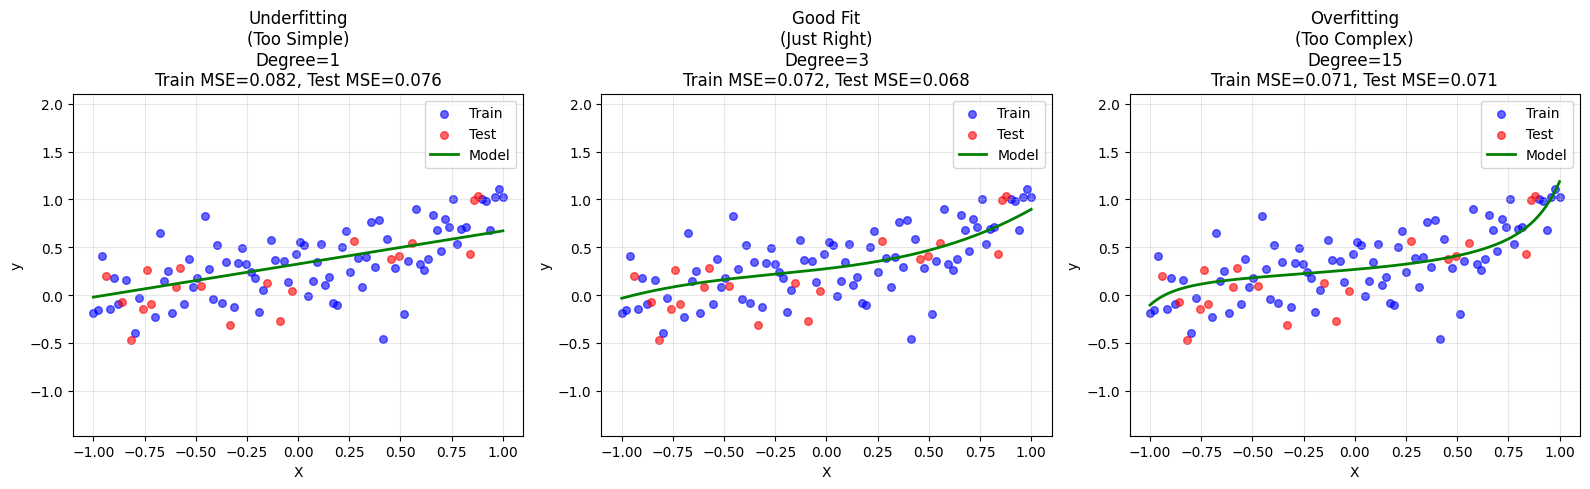

Key Observations:
1. Underfitting: Both train and test errors are high (high bias)
2. Good Fit: Both train and test errors are low and similar
3. Overfitting: Train error is very low, but test error is high (high variance)


In [26]:
# Compare underfitting, good fit, and overfitting
degrees = [1, 3, 15]
titles = ['Underfitting\n(Too Simple)', 'Good Fit\n(Just Right)', 'Overfitting\n(Too Complex)']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (deg, title) in enumerate(zip(degrees, titles)):
    # Create polynomial features
    X_train_poly = create_polynomial_features(X_train, deg)
    X_test_poly = create_polynomial_features(X_test, deg)
    
    # Train model
    model = RegularizedRegression(regularization='none', learning_rate=0.001, n_iterations=3000)
    model.fit(X_train_poly, y_train, X_test_poly, y_test)
    
    # Calculate errors
    train_mse = model.get_mse(X_train_poly, y_train)
    test_mse = model.get_mse(X_test_poly, y_test)
    
    # Plot
    ax = axes[idx]
    
    # Predictions
    X_plot = np.linspace(X.min(), X.max(), 200)
    X_plot_poly = create_polynomial_features(X_plot, deg)
    y_plot = model.predict(X_plot_poly)
    
    ax.scatter(X_train, y_train, alpha=0.6, color='blue', s=30, label='Train')
    ax.scatter(X_test, y_test, alpha=0.6, color='red', s=30, label='Test')
    ax.plot(X_plot, y_plot, 'g-', linewidth=2, label='Model')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'{title}\nDegree={deg}\nTrain MSE={train_mse:.3f}, Test MSE={test_mse:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y.min() - 1, y.max() + 1)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("=" * 70)
print("1. Underfitting: Both train and test errors are high (high bias)")
print("2. Good Fit: Both train and test errors are low and similar")
print("3. Overfitting: Train error is very low, but test error is high (high variance)")

## Step 6: L2 Regularization (Ridge)

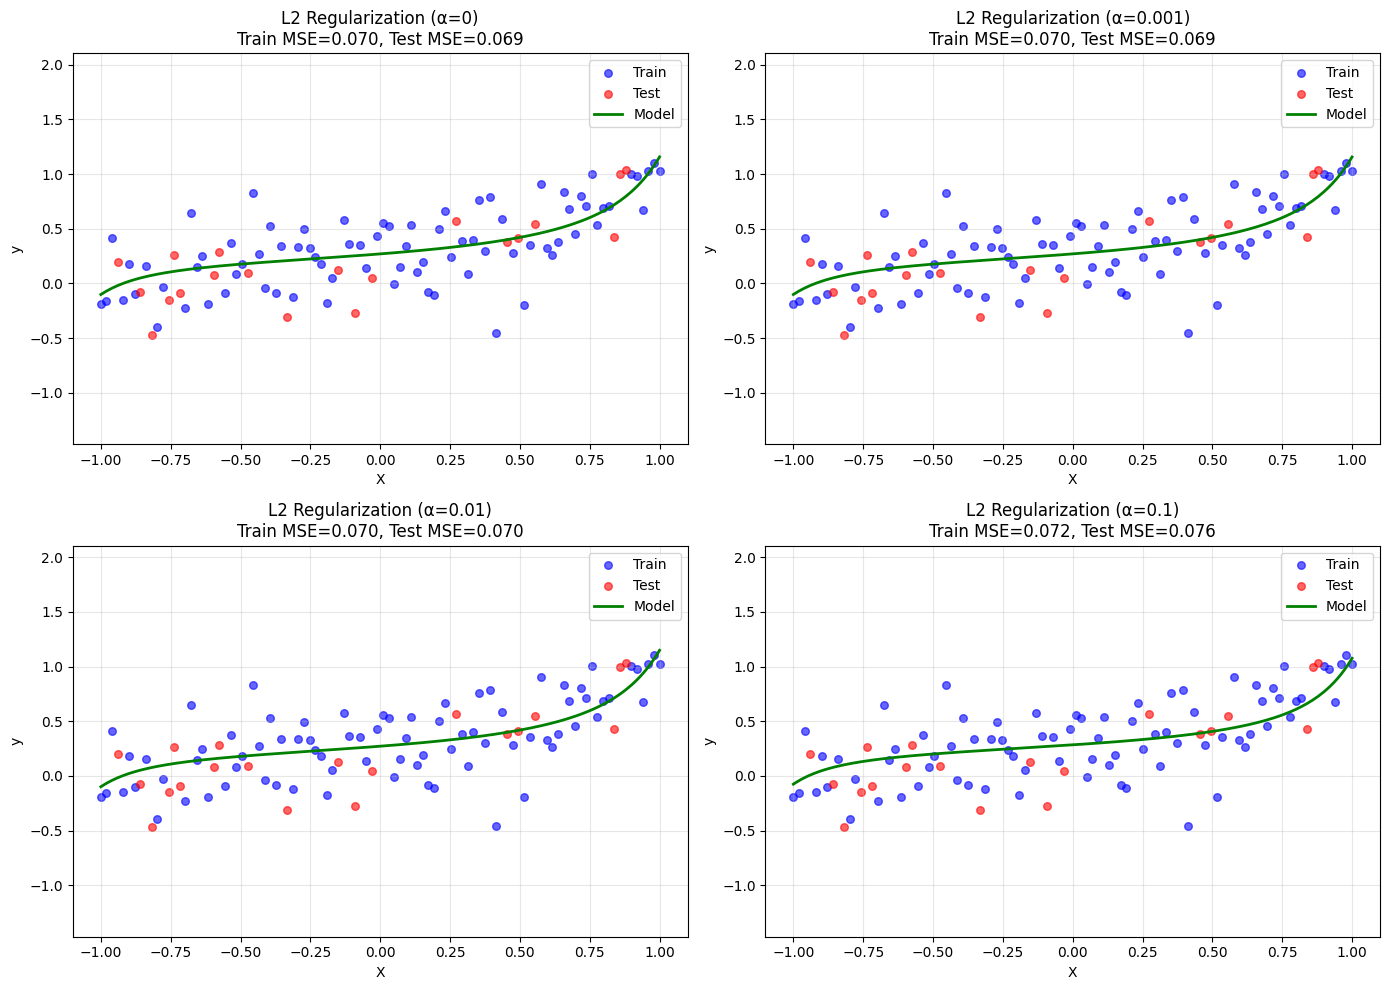

L2 Regularization Results:
Alpha      Train MSE       Test MSE        Max |Weight|   
0          0.0704          0.0693          0.2016         
0.001      0.0704          0.0694          0.2013         
0.01       0.0704          0.0700          0.1979         
0.1        0.0717          0.0765          0.1702         

✓ L2 regularization shrinks weights, reducing overfitting!


In [27]:
# Use high degree polynomial with L2 regularization
degree = 15
X_train_poly = create_polynomial_features(X_train, degree)
X_test_poly = create_polynomial_features(X_test, degree)

# Try different regularization strengths
alphas = [0, 0.001, 0.01, 0.1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

results = []

for idx, alpha in enumerate(alphas):
    # Train model with L2 regularization
    model = RegularizedRegression(regularization='l2', alpha=alpha, 
                                   learning_rate=0.001, n_iterations=5000)
    model.fit(X_train_poly, y_train, X_test_poly, y_test)
    
    # Calculate errors
    train_mse = model.get_mse(X_train_poly, y_train)
    test_mse = model.get_mse(X_test_poly, y_test)
    
    results.append({
        'alpha': alpha,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'weights': model.weights.copy()
    })
    
    # Plot
    ax = axes[idx]
    
    X_plot = np.linspace(X.min(), X.max(), 200)
    X_plot_poly = create_polynomial_features(X_plot, degree)
    y_plot = model.predict(X_plot_poly)
    
    ax.scatter(X_train, y_train, alpha=0.6, color='blue', s=30, label='Train')
    ax.scatter(X_test, y_test, alpha=0.6, color='red', s=30, label='Test')
    ax.plot(X_plot, y_plot, 'g-', linewidth=2, label='Model')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'L2 Regularization (α={alpha})\nTrain MSE={train_mse:.3f}, Test MSE={test_mse:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y.min() - 1, y.max() + 1)

plt.tight_layout()
plt.show()

# Print summary
print("L2 Regularization Results:")
print("=" * 70)
print(f"{'Alpha':<10} {'Train MSE':<15} {'Test MSE':<15} {'Max |Weight|':<15}")
print("=" * 70)
for r in results:
    print(f"{r['alpha']:<10} {r['train_mse']:<15.4f} {r['test_mse']:<15.4f} {np.max(np.abs(r['weights'])):<15.4f}")
print("=" * 70)
print("\n✓ L2 regularization shrinks weights, reducing overfitting!")

## Step 7: L1 Regularization (Lasso)

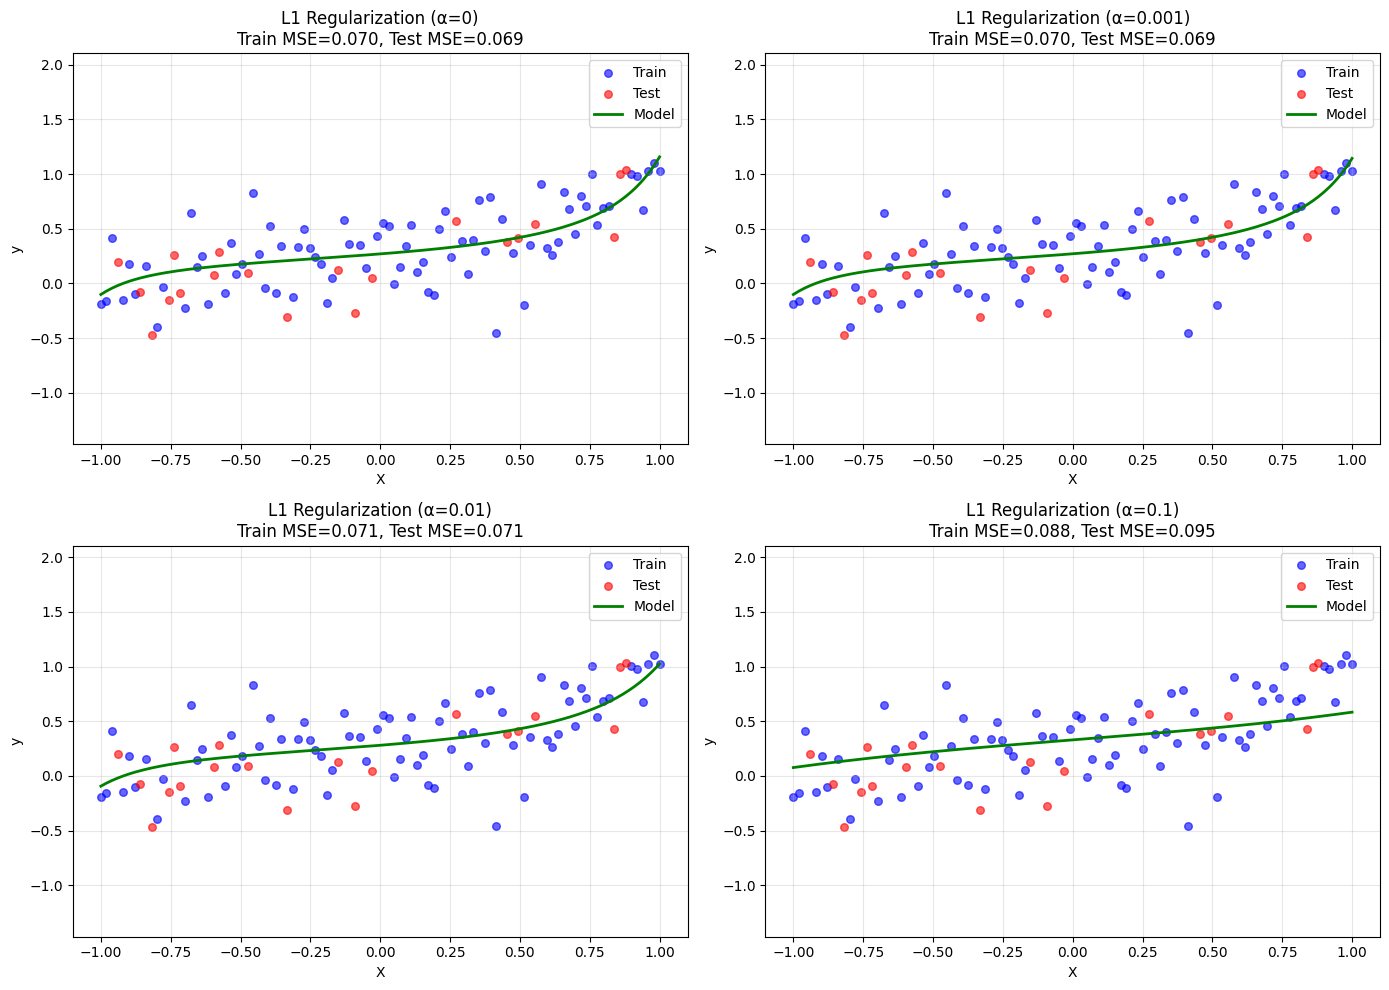

L1 Regularization Results:
Alpha      Train MSE       Test MSE        ~Zero Weights   % Sparse  
0          0.0704          0.0693          1               6.7       %
0.001      0.0703          0.0695          1               6.7       %
0.01       0.0707          0.0711          5               33.3      %
0.1        0.0884          0.0951          13              86.7      %

✓ L1 regularization creates sparse models (many weights → 0)!


In [28]:
# Try L1 regularization with different strengths
alphas_l1 = [0, 0.001, 0.01, 0.1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

results_l1 = []

for idx, alpha in enumerate(alphas_l1):
    # Train model with L1 regularization
    model = RegularizedRegression(regularization='l1', alpha=alpha, 
                                   learning_rate=0.001, n_iterations=5000)
    model.fit(X_train_poly, y_train, X_test_poly, y_test)
    
    # Calculate errors
    train_mse = model.get_mse(X_train_poly, y_train)
    test_mse = model.get_mse(X_test_poly, y_test)
    
    # Count zero weights (sparsity)
    zero_weights = np.sum(np.abs(model.weights) < 0.01)
    
    results_l1.append({
        'alpha': alpha,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'weights': model.weights.copy(),
        'zero_weights': zero_weights
    })
    
    # Plot
    ax = axes[idx]
    
    X_plot = np.linspace(X.min(), X.max(), 200)
    X_plot_poly = create_polynomial_features(X_plot, degree)
    y_plot = model.predict(X_plot_poly)
    
    ax.scatter(X_train, y_train, alpha=0.6, color='blue', s=30, label='Train')
    ax.scatter(X_test, y_test, alpha=0.6, color='red', s=30, label='Test')
    ax.plot(X_plot, y_plot, 'g-', linewidth=2, label='Model')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'L1 Regularization (α={alpha})\nTrain MSE={train_mse:.3f}, Test MSE={test_mse:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(y.min() - 1, y.max() + 1)

plt.tight_layout()
plt.show()

# Print summary
print("L1 Regularization Results:")
print("=" * 80)
print(f"{'Alpha':<10} {'Train MSE':<15} {'Test MSE':<15} {'~Zero Weights':<15} {'% Sparse':<10}")
print("=" * 80)
for r in results_l1:
    sparsity = (r['zero_weights'] / len(r['weights'])) * 100
    print(f"{r['alpha']:<10} {r['train_mse']:<15.4f} {r['test_mse']:<15.4f} {r['zero_weights']:<15} {sparsity:<10.1f}%")
print("=" * 80)
print("\n✓ L1 regularization creates sparse models (many weights → 0)!")

## Step 8: Compare L1 vs L2 Weight Patterns

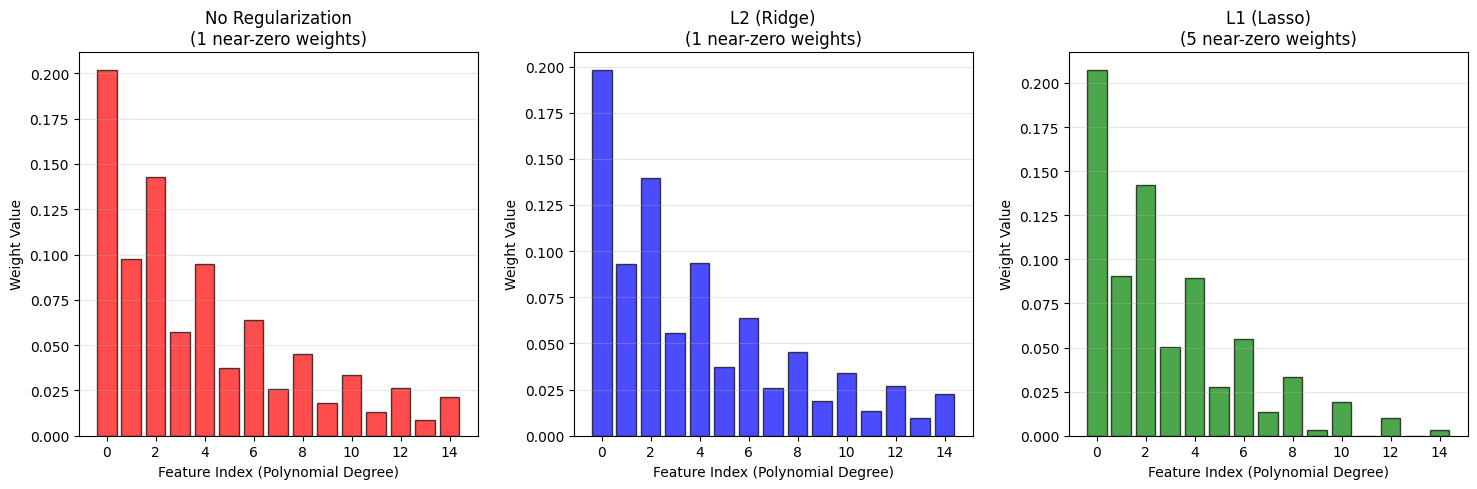

Weight Statistics Comparison:
Metric                    No Reg          L2              L1             
Max |weight|              0.2016          0.1979          0.2071         
Mean |weight|             0.0591          0.0584          0.0496         
# Near-zero weights       1               1               5              

Key Differences:
• L2: Shrinks all weights proportionally (smooth reduction)
• L1: Forces some weights to exactly zero (feature selection)


In [29]:
# Train models with same alpha for comparison
alpha = 0.01

# No regularization
model_none = RegularizedRegression(regularization='none', learning_rate=0.001, n_iterations=5000)
model_none.fit(X_train_poly, y_train)

# L2 regularization
model_l2 = RegularizedRegression(regularization='l2', alpha=alpha, 
                                  learning_rate=0.001, n_iterations=5000)
model_l2.fit(X_train_poly, y_train)

# L1 regularization
model_l1 = RegularizedRegression(regularization='l1', alpha=alpha, 
                                  learning_rate=0.001, n_iterations=5000)
model_l1.fit(X_train_poly, y_train)

# Visualize weight patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = [model_none, model_l2, model_l1]
titles = ['No Regularization', 'L2 (Ridge)', 'L1 (Lasso)']
colors = ['red', 'blue', 'green']

for idx, (model, title, color) in enumerate(zip(models, titles, colors)):
    ax = axes[idx]
    
    weights = model.weights
    feature_indices = np.arange(len(weights))
    
    ax.bar(feature_indices, weights, color=color, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Feature Index (Polynomial Degree)')
    ax.set_ylabel('Weight Value')
    ax.set_title(f'{title}\n({np.sum(np.abs(weights) < 0.01)} near-zero weights)')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Compare weight statistics
print("Weight Statistics Comparison:")
print("=" * 70)
print(f"{'Metric':<25} {'No Reg':<15} {'L2':<15} {'L1':<15}")
print("=" * 70)
print(f"{'Max |weight|':<25} {np.max(np.abs(model_none.weights)):<15.4f} {np.max(np.abs(model_l2.weights)):<15.4f} {np.max(np.abs(model_l1.weights)):<15.4f}")
print(f"{'Mean |weight|':<25} {np.mean(np.abs(model_none.weights)):<15.4f} {np.mean(np.abs(model_l2.weights)):<15.4f} {np.mean(np.abs(model_l1.weights)):<15.4f}")
print(f"{'# Near-zero weights':<25} {np.sum(np.abs(model_none.weights) < 0.01):<15} {np.sum(np.abs(model_l2.weights) < 0.01):<15} {np.sum(np.abs(model_l1.weights) < 0.01):<15}")
print("=" * 70)
print("\nKey Differences:")
print("• L2: Shrinks all weights proportionally (smooth reduction)")
print("• L1: Forces some weights to exactly zero (feature selection)")

## Step 9: Regularization Path (Alpha Selection)

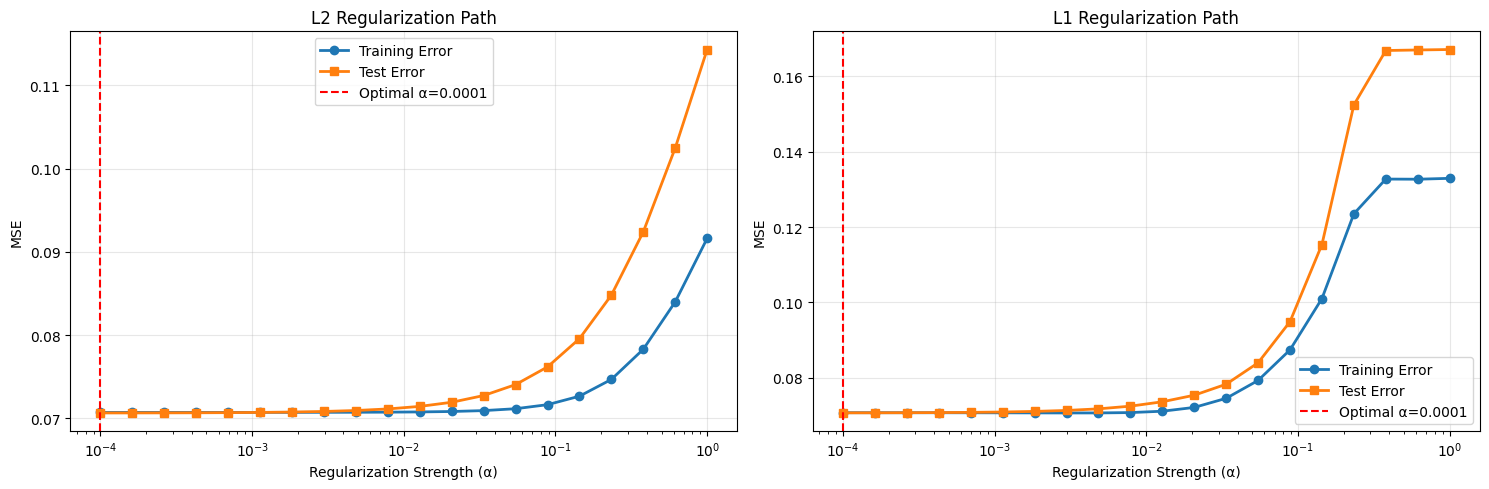

Optimal Regularization Strengths:
L2 (Ridge): α = 0.0001
  - Train MSE: 0.0707
  - Test MSE: 0.0707

L1 (Lasso): α = 0.0001
  - Train MSE: 0.0707
  - Test MSE: 0.0707

✓ Optimal α balances training error and generalization!


In [30]:
# Test a range of alpha values to find optimal regularization
alphas_range = np.logspace(-4, 0, 20)  # 0.0001 to 1.0

train_errors_l2 = []
test_errors_l2 = []
train_errors_l1 = []
test_errors_l1 = []

for alpha in alphas_range:
    # L2
    model_l2 = RegularizedRegression(regularization='l2', alpha=alpha, 
                                      learning_rate=0.001, n_iterations=3000)
    model_l2.fit(X_train_poly, y_train)
    train_errors_l2.append(model_l2.get_mse(X_train_poly, y_train))
    test_errors_l2.append(model_l2.get_mse(X_test_poly, y_test))
    
    # L1
    model_l1 = RegularizedRegression(regularization='l1', alpha=alpha, 
                                      learning_rate=0.001, n_iterations=3000)
    model_l1.fit(X_train_poly, y_train)
    train_errors_l1.append(model_l1.get_mse(X_train_poly, y_train))
    test_errors_l1.append(model_l1.get_mse(X_test_poly, y_test))

# Find optimal alphas
optimal_alpha_l2 = alphas_range[np.argmin(test_errors_l2)]
optimal_alpha_l1 = alphas_range[np.argmin(test_errors_l1)]

# Plot regularization path
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# L2 regularization path
ax = axes[0]
ax.plot(alphas_range, train_errors_l2, 'o-', label='Training Error', linewidth=2)
ax.plot(alphas_range, test_errors_l2, 's-', label='Test Error', linewidth=2)
ax.axvline(x=optimal_alpha_l2, color='red', linestyle='--', 
           label=f'Optimal α={optimal_alpha_l2:.4f}')
ax.set_xscale('log')
ax.set_xlabel('Regularization Strength (α)')
ax.set_ylabel('MSE')
ax.set_title('L2 Regularization Path')
ax.legend()
ax.grid(True, alpha=0.3)

# L1 regularization path
ax = axes[1]
ax.plot(alphas_range, train_errors_l1, 'o-', label='Training Error', linewidth=2)
ax.plot(alphas_range, test_errors_l1, 's-', label='Test Error', linewidth=2)
ax.axvline(x=optimal_alpha_l1, color='red', linestyle='--', 
           label=f'Optimal α={optimal_alpha_l1:.4f}')
ax.set_xscale('log')
ax.set_xlabel('Regularization Strength (α)')
ax.set_ylabel('MSE')
ax.set_title('L1 Regularization Path')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Optimal Regularization Strengths:")
print("=" * 70)
print(f"L2 (Ridge): α = {optimal_alpha_l2:.4f}")
print(f"  - Train MSE: {train_errors_l2[np.argmin(test_errors_l2)]:.4f}")
print(f"  - Test MSE: {min(test_errors_l2):.4f}")
print()
print(f"L1 (Lasso): α = {optimal_alpha_l1:.4f}")
print(f"  - Train MSE: {train_errors_l1[np.argmin(test_errors_l1)]:.4f}")
print(f"  - Test MSE: {min(test_errors_l1):.4f}")
print("=" * 70)
print("\n✓ Optimal α balances training error and generalization!")

## Step 10: Bias-Variance Tradeoff Visualization

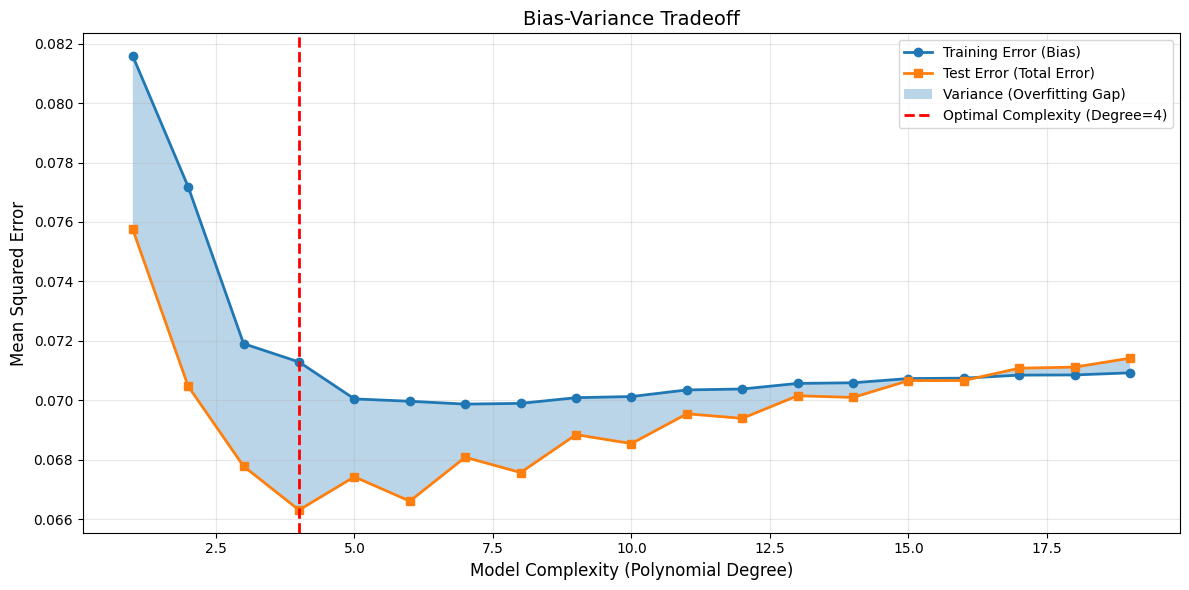

Bias-Variance Tradeoff Analysis:
Optimal Model Complexity: Degree 4
  - Training Error (Bias): 0.0713
  - Test Error (Total): 0.0663
  - Variance: -0.0050

Key Insights:
  • Low complexity → High bias (underfitting)
  • High complexity → High variance (overfitting)
  • Optimal complexity → Balance between bias and variance


In [31]:
# Visualize bias-variance tradeoff across model complexity
degrees_range = range(1, 20)
train_errors = []
test_errors = []

for deg in degrees_range:
    X_train_poly = create_polynomial_features(X_train, deg)
    X_test_poly = create_polynomial_features(X_test, deg)
    
    # Train without regularization
    model = RegularizedRegression(regularization='none', learning_rate=0.001, n_iterations=3000)
    model.fit(X_train_poly, y_train)
    
    train_errors.append(model.get_mse(X_train_poly, y_train))
    test_errors.append(model.get_mse(X_test_poly, y_test))

# Find optimal complexity
optimal_degree = degrees_range[np.argmin(test_errors)]

# Plot
plt.figure(figsize=(12, 6))

plt.plot(degrees_range, train_errors, 'o-', label='Training Error (Bias)', 
         linewidth=2, markersize=6)
plt.plot(degrees_range, test_errors, 's-', label='Test Error (Total Error)', 
         linewidth=2, markersize=6)

# Calculate and plot variance component
variance = np.array(test_errors) - np.array(train_errors)
plt.fill_between(degrees_range, train_errors, test_errors, 
                 alpha=0.3, label='Variance (Overfitting Gap)')

plt.axvline(x=optimal_degree, color='red', linestyle='--', 
            label=f'Optimal Complexity (Degree={optimal_degree})', linewidth=2)

plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title('Bias-Variance Tradeoff', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Bias-Variance Tradeoff Analysis:")
print("=" * 70)
print(f"Optimal Model Complexity: Degree {optimal_degree}")
print(f"  - Training Error (Bias): {train_errors[optimal_degree-1]:.4f}")
print(f"  - Test Error (Total): {test_errors[optimal_degree-1]:.4f}")
print(f"  - Variance: {variance[optimal_degree-1]:.4f}")
print()
print("Key Insights:")
print("  • Low complexity → High bias (underfitting)")
print("  • High complexity → High variance (overfitting)")
print("  • Optimal complexity → Balance between bias and variance")
print("=" * 70)

## Step 11: Learning Curves Analysis

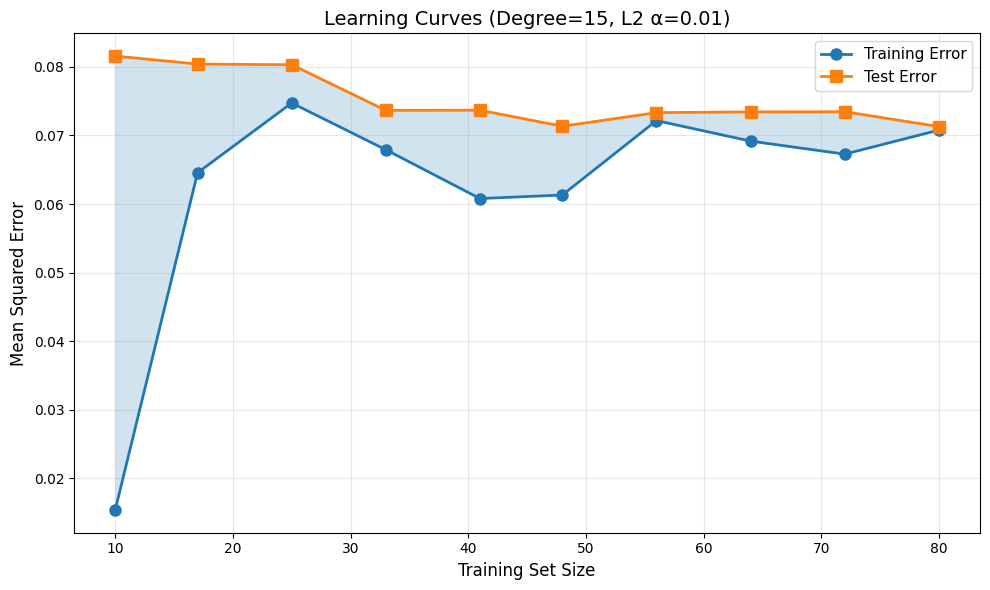

Learning Curves Insights:
• As training size increases:
  - Training error increases (harder to fit all points perfectly)
  - Test error decreases (model generalizes better)
  - Gap between them decreases (less overfitting)

• More data helps reduce overfitting!


In [32]:
# Learning curves: Error vs training set size
degree = 15
train_sizes = np.linspace(10, len(X_train), 10, dtype=int)

train_errors_curve = []
test_errors_curve = []

for size in train_sizes:
    X_train_subset = X_train[:size]
    y_train_subset = y_train[:size]
    
    X_train_poly_subset = create_polynomial_features(X_train_subset, degree)
    X_test_poly_full = create_polynomial_features(X_test, degree)
    
    # Train model
    model = RegularizedRegression(regularization='l2', alpha=0.01, 
                                   learning_rate=0.001, n_iterations=3000)
    model.fit(X_train_poly_subset, y_train_subset)
    
    train_errors_curve.append(model.get_mse(X_train_poly_subset, y_train_subset))
    test_errors_curve.append(model.get_mse(X_test_poly_full, y_test))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors_curve, 'o-', label='Training Error', linewidth=2, markersize=8)
plt.plot(train_sizes, test_errors_curve, 's-', label='Test Error', linewidth=2, markersize=8)
plt.fill_between(train_sizes, train_errors_curve, test_errors_curve, alpha=0.2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(f'Learning Curves (Degree={degree}, L2 α=0.01)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Learning Curves Insights:")
print("=" * 70)
print("• As training size increases:")
print("  - Training error increases (harder to fit all points perfectly)")
print("  - Test error decreases (model generalizes better)")
print("  - Gap between them decreases (less overfitting)")
print()
print("• More data helps reduce overfitting!")
print("=" * 70)

## Key Insights and Learning Summary

### What is Overfitting vs Underfitting?
- **Underfitting (High Bias)**: Model is too simple, fails to capture patterns in data
  - Both training and test errors are high
  - Model doesn't learn enough from the data
  
- **Overfitting (High Variance)**: Model is too complex, memorizes training data including noise
  - Training error is very low, but test error is high
  - Model doesn't generalize to new data
  
- **Good Fit**: Model captures true patterns without memorizing noise
  - Both training and test errors are reasonably low and similar

### L1 vs L2 Regularization
**L2 (Ridge Regularization):**
- Adds penalty: $\lambda \sum w_i^2$
- Shrinks all weights proportionally
- Keeps all features but reduces their influence
- Smooth, continuous weight reduction
- Better when all features are relevant

**L1 (Lasso Regularization):**
- Adds penalty: $\lambda \sum |w_i|$
- Forces some weights to exactly zero
- Performs automatic feature selection
- Creates sparse models (many zero weights)
- Better when only some features are relevant

### Bias-Variance Tradeoff
- **Bias**: Error from overly simple models (underfitting)
- **Variance**: Error from overly complex models (overfitting)
- **Total Error** = Bias² + Variance + Irreducible Error
- Regularization helps control this tradeoff by limiting model complexity

### Training vs Test Loss Divergence
- **Healthy model**: Train and test losses both decrease and stay close
- **Overfitting**: Train loss keeps decreasing, test loss increases
- **Underfitting**: Both losses remain high and don't improve much
- **Solution**: Use regularization, more data, or adjust model complexity